## t-NNCLR (Time Series Nearest-Neighbor Contrastive Learning of Representations)
### This notebook implements and evaluates the t-NNCLR method for time series classification. The approach uses self-supervised learning to learn meaningful representations from unlabeled time series data, which are then fine-tuned for classification tasks.

### 1. Import Required Libraries

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import logging
from datetime import datetime
import os
import gdown
import sys

sys.path.append('..')

# Import local modules
from pretrain import pretrain
from finetune import finetune, FineTuningConfig
from utils.config import *
from utils.data_loader import load_and_preprocess_har_data

### 2. Download Data
Before we start, we need to download the HAR (Human Activity Recognition) dataset. This data consists of sensor measurements from wearable devices and corresponding activity labels.

In [2]:
def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive.
    
    Args:
        file_id: Google Drive file ID
        destination: Local destination path
    """
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, destination, quiet=False)

# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Define file IDs and destination paths
files_to_download = [
    {
        'file_id': '1vK1flNSOMADCmYnxQjSHoq3FupZ42Anq',
        'dest_path': 'data/X_unlabeled.npy'
    },
    {
        'file_id': '1sXJX-1Tge5voIPXxFhMene1HLKhfp9gm',
        'dest_path': 'data/X.npy'
    },
    {
        'file_id': '1jgNQ2M5mrtjqo7V_fCpHbGigslc1jjOC',
        'dest_path': 'data/y.npy'
    },
    {
        'file_id': '1ZXSvlVzxipCP_EDsUMtPE4TM0ygVMxaJ',
        'dest_path': 'data/sub.npy'
    },
]

# Download each file
for file_info in files_to_download:
    print(f"Downloading {file_info['dest_path']}...")
    download_file_from_google_drive(file_info['file_id'], file_info['dest_path'])
    print(f"Downloaded {file_info['dest_path']}.\n")

Downloading...
From (original): https://drive.google.com/uc?id=1vK1flNSOMADCmYnxQjSHoq3FupZ42Anq
From (redirected): https://drive.google.com/uc?id=1vK1flNSOMADCmYnxQjSHoq3FupZ42Anq&confirm=t&uuid=cc1dcfe2-d1e9-46de-9e5f-06dcaa959843
To: /mnt/batch/tasks/shared/LS_root/mounts/clusters/habibirani-gpu/code/Users/habibirani/t-nnclr/data/X_unlabeled.npy
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Downloaded data/X_unlabeled.npy.



Downloading...
From: https://drive.google.com/uc?id=1sXJX-1Tge5voIPXxFhMene1HLKhfp9gm
To: /mnt/batch/tasks/shared/LS_root/mounts/clusters/habibirani-gpu/code/Users/habibirani/t-nnclr/data/X.npy
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Downloaded data/X.npy.



Downloading...
From: https://drive.google.com/uc?id=1jgNQ2M5mrtjqo7V_fCpHbGigslc1jjOC
To: /mnt/batch/tasks/shared/LS_root/mounts/clusters/habibirani-gpu/code/Users/habibirani/t-nnclr/data/y.npy
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Downloaded data/y.npy.



Downloading...
From: https://drive.google.com/uc?id=1ZXSvlVzxipCP_EDsUMtPE4TM0ygVMxaJ
To: /mnt/batch/tasks/shared/LS_root/mounts/clusters/habibirani-gpu/code/Users/habibirani/t-nnclr/data/sub.npy
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Downloaded data/sub.npy.



### 3. Data Loading and Preprocessing

In [3]:
def load_and_preprocess_har_data(data_dir='./data', logger=None):
    """
    Load and preprocess HAR dataset.
    
    Args:
        data_dir: Directory containing the data files
        logger: Optional logger instance
    
    Returns:
        tuple: (X_unlabeled, X_labeled, y, subjects)
            - X_unlabeled: Unlabeled data array
            - X_labeled: Labeled data array
            - y: Labels array
            - subjects: Subject IDs array
    """
    try:
        data_dir = Path(data_dir)
        
        # Load data
        X_unlabeled = np.load(data_dir / 'X_unlabeled.npy')
        X_labeled = np.load(data_dir / 'X.npy')
        y = np.load(data_dir / 'y.npy').squeeze()
        subjects = np.load(data_dir / 'sub.npy').squeeze()
        
        # Use only first 4 channels of the data
        X_unlabeled = X_unlabeled[:, :, :4]
        X_labeled = X_labeled[:, :, :4]
        
        if logger:
            logger.info(f"Loaded data shapes:")
            logger.info(f"X_unlabeled: {X_unlabeled.shape}")
            logger.info(f"X_labeled: {X_labeled.shape}")
            logger.info(f"y: {y.shape}")
            logger.info(f"subjects: {subjects.shape}")
            logger.info(f"Number of unique subjects: {len(np.unique(subjects))}")
            logger.info(f"Number of unique classes: {len(np.unique(y))}")
        
        # Convert labels to integers
        le = LabelEncoder()
        y = le.fit_transform(y)
        if logger:
            logger.info("Labels encoded successfully")
        
        # Standardize the data
        scaler = StandardScaler()
        
        # Reshape for standardization
        orig_shape_unlabeled = X_unlabeled.shape
        orig_shape_labeled = X_labeled.shape
        
        # Combine all data for computing statistics
        combined = np.vstack([
            X_unlabeled.reshape(-1, X_unlabeled.shape[-1]),
            X_labeled.reshape(-1, X_labeled.shape[-1])
        ])
        
        # Fit on combined data
        scaler.fit(combined)
        
        # Transform separately and reshape back
        X_unlabeled = scaler.transform(
            X_unlabeled.reshape(-1, X_unlabeled.shape[-1])
        ).reshape(orig_shape_unlabeled)
        
        X_labeled = scaler.transform(
            X_labeled.reshape(-1, X_labeled.shape[-1])
        ).reshape(orig_shape_labeled)
        
        if logger:
            logger.info("Data standardization completed")
        
        return X_unlabeled, X_labeled, y, subjects
        
    except Exception as e:
        if logger:
            logger.error(f"Error loading data: {str(e)}")
        raise

# Test data loading
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

data_dir = Path.cwd() / 'data'
X_unlabeled, X_labeled, y, subjects = load_and_preprocess_har_data(data_dir, logger)

print("\nData loading test completed successfully!")
print(f"Unlabeled data shape: {X_unlabeled.shape}")
print(f"Labeled data shape: {X_labeled.shape}")
print(f"Labels shape: {y.shape}")
print(f"Subjects shape: {subjects.shape}")

INFO:__main__:Loaded data shapes:
INFO:__main__:X_unlabeled: (331964, 96, 4)
INFO:__main__:X_labeled: (3168, 96, 4)
INFO:__main__:y: (3168,)
INFO:__main__:subjects: (3168,)
INFO:__main__:Number of unique subjects: 3
INFO:__main__:Number of unique classes: 6
INFO:__main__:Labels encoded successfully
INFO:__main__:Data standardization completed



Data loading test completed successfully!
Unlabeled data shape: (331964, 96, 4)
Labeled data shape: (3168, 96, 4)
Labels shape: (3168,)
Subjects shape: (3168,)


### 4. Set up Experiment Directory and Logging
This function sets up the logging configuration for the experiment.

In [4]:
def setup_logging(experiment_dir):
    """
    Setup logging configuration.
    
    Args:
        experiment_dir: Directory to save experiment logs
        
    Returns:
        logger: Configured logger instance
    """
    experiment_dir.mkdir(parents=True, exist_ok=True)
    
    log_file = experiment_dir / 'experiment.log'
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

# Create experiment directory
experiment_dir = Path.cwd() / 'experiments' / datetime.now().strftime('%Y%m%d_%H%M%S')
logger = setup_logging(experiment_dir)

### 5. Pretraining Phase
In this section, we perform self-supervised pretraining using the t-NNCLR method on unlabeled data.

INFO:__main__:Using device: cuda
INFO:__main__:Starting pretraining phase...


Pretraining on device: cuda
Unlabeled data shape: (331964, 96, 4)

Starting pretraining...


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [02:00<00:00, 43.21it/s, loss=0.6229]



Epoch 1/10
Loss: 0.6228


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:55<00:00, 44.71it/s, loss=0.3769]



Epoch 2/10
Loss: 0.3768


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:55<00:00, 44.80it/s, loss=0.3476]



Epoch 3/10
Loss: 0.3476


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:55<00:00, 44.71it/s, loss=0.3431]



Epoch 4/10
Loss: 0.3430


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:56<00:00, 44.67it/s, loss=0.3406]



Epoch 5/10
Loss: 0.3406


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:56<00:00, 44.62it/s, loss=0.3409]



Epoch 6/10
Loss: 0.3408


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:54<00:00, 45.24it/s, loss=0.3288]



Epoch 7/10
Loss: 0.3288


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:54<00:00, 45.29it/s, loss=0.3300]



Epoch 8/10
Loss: 0.3299


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:53<00:00, 45.67it/s, loss=0.3252]



Epoch 9/10
Loss: 0.3252


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5186/5186 [01:52<00:00, 45.91it/s, loss=0.3265]



Epoch 10/10
Loss: 0.3264

Model saved to /mnt/batch/tasks/shared/LS_root/mounts/clusters/habibirani-gpu/code/Users/habibirani/t-nnclr/experiments/20250324_202726/pretrained_model.pt
Pretraining history structure: <class 'dict'>
Keys in pretrain_history: dict_keys(['loss'])


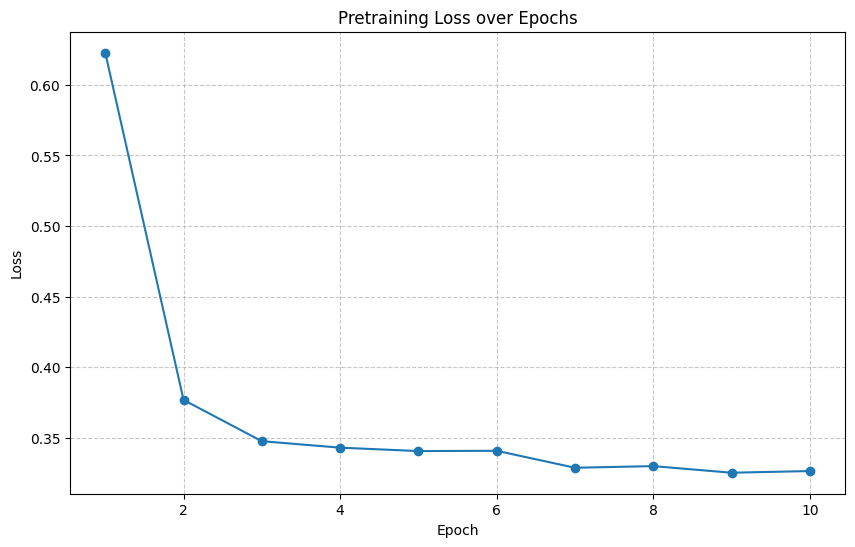

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

pretrain_epochs = 10 

# Perform pretraining once using only unlabeled data
logger.info("Starting pretraining phase...")
pretrain_save_path = experiment_dir / 'pretrained_model.pt'

pretrained_model, pretrain_history = pretrain(
    X_unlabeled=X_unlabeled,
    num_epochs=pretrain_epochs,
    device=device,
    save_path=pretrain_save_path
)

# Save pretraining history
np.save(experiment_dir / 'pretrain_history.npy', pretrain_history)

# First, let's examine the structure of pretrain_history
print("Pretraining history structure:", type(pretrain_history))
if isinstance(pretrain_history, dict):
    print("Keys in pretrain_history:", pretrain_history.keys())
else:
    print("First few values:", pretrain_history[:5] if len(pretrain_history) > 5 else pretrain_history)

# Plot training history - adjusting based on the actual structure
plt.figure(figsize=(10, 6))

# If pretrain_history is a list of loss values (one per epoch)
if isinstance(pretrain_history, list) or isinstance(pretrain_history, np.ndarray):
    plt.plot(range(1, len(pretrain_history) + 1), pretrain_history, marker='o')
    
# If pretrain_history is a dictionary with 'loss' key
elif isinstance(pretrain_history, dict) and 'loss' in pretrain_history:
    plt.plot(range(1, len(pretrain_history['loss']) + 1), pretrain_history['loss'], marker='o')
    
# If pretrain_history is a dictionary with epoch numbers as keys
elif isinstance(pretrain_history, dict) and all(isinstance(k, int) for k in pretrain_history.keys()):
    epochs = sorted(pretrain_history.keys())
    losses = [pretrain_history[e] for e in epochs]
    plt.plot(epochs, losses, marker='o')
    
# Fallback - try to convert to numpy array and plot
else:
    try:
        losses = np.array(pretrain_history)
        plt.plot(range(1, len(losses) + 1), losses, marker='o')
    except:
        print("Could not plot pretrain_history - incompatible format")

plt.title('Pretraining Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(experiment_dir / 'pretrain_loss.png')
plt.show()

### 6. Cross-Validation Fine-tuning
Now we'll perform fine-tuning and evaluation using Leave-One-Subject-Out cross-validation.

In [6]:
# Create fine-tuning configuration with increased epochs
finetune_epochs = 10  # Increased from default
finetune_config = FineTuningConfig(
    freeze_encoder=False,
    encoder_lr=LEARNING_RATE,
    head_lr=LEARNING_RATE,
    num_epochs=finetune_epochs
)

# Setup cross-validation
cv = LeaveOneGroupOut()
splits = list(cv.split(X_labeled, y, subjects))
logger.info(f"Running Leave-One-Subject-Out CV with {len(splits)} folds")

# Initialize results containers
results = {
    'fold_accuracies': [],
    'confusion_matrices': [],
    'finetune_histories': []
}

# Run cross-validation
for fold, (train_idx, test_idx) in enumerate(splits):
    fold_dir = experiment_dir / f'fold_{fold}'
    fold_dir.mkdir(exist_ok=True)
    
    logger.info(f"\nStarting Fold {fold + 1}/{len(splits)}")
    
    # Split data for this fold
    X_train = X_labeled[train_idx]
    y_train = y[train_idx]
    X_test = X_labeled[test_idx]
    y_test = y[test_idx]
    
    # Finetuning phase
    logger.info("Starting finetuning phase...")
    finetune_save_path = fold_dir / 'finetuned_model.pt'
    
    # Fine-tune using pretrained weights
    model, finetune_history = finetune(
        pretrained_model_path=pretrain_save_path,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        config=finetune_config,
        device=device,
        save_path=finetune_save_path
    )


INFO:__main__:Running Leave-One-Subject-Out CV with 3 folds
INFO:__main__:
Starting Fold 1/3
INFO:__main__:Starting finetuning phase...
/mnt/batch/tasks/shared/LS_root/mounts/clusters/habibirani-gpu/code/Users/habibirani/t-nnclr/finetune.py:247: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have 

Finetuning on device: cuda
Training data shape: (2121, 96, 4)
Test data shape: (1047, 96, 4)
Encoder frozen: False
Encoder LR: 0.001
Head LR: 0.001

Starting finetuning...


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 70.74it/s, loss=1.8718, acc=60.82%]



Epoch 1/10
Train Loss: 1.4314 | Train Acc: 60.82%
Test Loss: 1.2176 | Test Acc: 73.54%
Best Test Acc: 73.54%


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.39it/s, loss=1.0333, acc=77.65%]



Epoch 2/10
Train Loss: 0.9421 | Train Acc: 77.65%
Test Loss: 0.9730 | Test Acc: 66.28%
Best Test Acc: 73.54%


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.06it/s, loss=0.7524, acc=79.92%]



Epoch 3/10
Train Loss: 0.6639 | Train Acc: 79.92%
Test Loss: 0.9114 | Test Acc: 60.74%
Best Test Acc: 73.54%


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.05it/s, loss=0.5899, acc=81.94%]



Epoch 4/10
Train Loss: 0.5205 | Train Acc: 81.94%
Test Loss: 1.1393 | Test Acc: 51.77%
Best Test Acc: 73.54%


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 88.60it/s, loss=0.5138, acc=85.20%]



Epoch 5/10
Train Loss: 0.4383 | Train Acc: 85.20%
Test Loss: 0.9321 | Test Acc: 75.64%
Best Test Acc: 75.64%


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 91.03it/s, loss=0.3733, acc=89.91%]



Epoch 6/10
Train Loss: 0.3404 | Train Acc: 89.91%
Test Loss: 1.0721 | Test Acc: 71.25%
Best Test Acc: 75.64%


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 89.78it/s, loss=0.3080, acc=92.55%]



Epoch 7/10
Train Loss: 0.2717 | Train Acc: 92.55%
Test Loss: 1.0714 | Test Acc: 73.83%
Best Test Acc: 75.64%


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.54it/s, loss=0.2652, acc=92.60%]



Epoch 8/10
Train Loss: 0.2340 | Train Acc: 92.60%
Test Loss: 1.1243 | Test Acc: 70.39%
Best Test Acc: 75.64%


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.67it/s, loss=0.2066, acc=94.30%]



Epoch 9/10
Train Loss: 0.1884 | Train Acc: 94.30%
Test Loss: 0.8926 | Test Acc: 78.51%
Best Test Acc: 78.51%


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.90it/s, loss=0.2165, acc=93.82%]



Epoch 10/10
Train Loss: 0.1974 | Train Acc: 93.82%
Test Loss: 1.2219 | Test Acc: 71.73%
Best Test Acc: 78.51%
Finetuning on device: cuda
Training data shape: (2138, 96, 4)
Test data shape: (1030, 96, 4)
Encoder frozen: False
Encoder LR: 0.001
Head LR: 0.001

Starting finetuning...


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 89.28it/s, loss=1.6879, acc=58.98%]



Epoch 1/10
Train Loss: 1.4397 | Train Acc: 58.98%
Test Loss: 1.2534 | Test Acc: 63.50%
Best Test Acc: 63.50%


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.48it/s, loss=1.0745, acc=72.87%]



Epoch 2/10
Train Loss: 0.9797 | Train Acc: 72.87%
Test Loss: 0.8256 | Test Acc: 72.23%
Best Test Acc: 72.23%


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 89.36it/s, loss=0.8399, acc=75.35%]



Epoch 3/10
Train Loss: 0.7411 | Train Acc: 75.35%
Test Loss: 0.7296 | Test Acc: 69.51%
Best Test Acc: 72.23%


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 93.23it/s, loss=0.6686, acc=76.66%]



Epoch 4/10
Train Loss: 0.6096 | Train Acc: 76.66%
Test Loss: 0.7069 | Test Acc: 68.83%
Best Test Acc: 72.23%


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 92.68it/s, loss=0.6128, acc=76.10%]



Epoch 5/10
Train Loss: 0.5587 | Train Acc: 76.10%
Test Loss: 0.5743 | Test Acc: 80.00%
Best Test Acc: 80.00%


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.71it/s, loss=0.5577, acc=76.66%]



Epoch 6/10
Train Loss: 0.5085 | Train Acc: 76.66%
Test Loss: 0.5337 | Test Acc: 79.32%
Best Test Acc: 80.00%


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 88.97it/s, loss=0.5598, acc=80.92%]



Epoch 7/10
Train Loss: 0.4610 | Train Acc: 80.92%
Test Loss: 0.4792 | Test Acc: 86.89%
Best Test Acc: 86.89%


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 87.35it/s, loss=0.4922, acc=84.71%]



Epoch 8/10
Train Loss: 0.4053 | Train Acc: 84.71%
Test Loss: 0.5950 | Test Acc: 80.39%
Best Test Acc: 86.89%


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.15it/s, loss=0.4000, acc=86.11%]



Epoch 9/10
Train Loss: 0.3647 | Train Acc: 86.11%
Test Loss: 0.5992 | Test Acc: 73.40%
Best Test Acc: 86.89%


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 90.64it/s, loss=0.3682, acc=87.23%]



Epoch 10/10
Train Loss: 0.3357 | Train Acc: 87.23%
Test Loss: 0.7043 | Test Acc: 72.52%
Best Test Acc: 86.89%
Finetuning on device: cuda
Training data shape: (2077, 96, 4)
Test data shape: (1091, 96, 4)
Encoder frozen: False
Encoder LR: 0.001
Head LR: 0.001

Starting finetuning...


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 88.18it/s, loss=1.6592, acc=57.01%]



Epoch 1/10
Train Loss: 1.4581 | Train Acc: 57.01%
Test Loss: 1.2813 | Test Acc: 55.00%
Best Test Acc: 55.00%


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 89.83it/s, loss=1.0514, acc=71.74%]



Epoch 2/10
Train Loss: 0.9877 | Train Acc: 71.74%
Test Loss: 1.1361 | Test Acc: 59.03%
Best Test Acc: 59.03%


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 89.93it/s, loss=0.8163, acc=74.68%]



Epoch 3/10
Train Loss: 0.7668 | Train Acc: 74.68%
Test Loss: 1.1371 | Test Acc: 59.40%
Best Test Acc: 59.40%


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 92.38it/s, loss=0.6791, acc=75.83%]



Epoch 4/10
Train Loss: 0.6380 | Train Acc: 75.83%
Test Loss: 1.2047 | Test Acc: 61.96%
Best Test Acc: 61.96%


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 89.87it/s, loss=0.5918, acc=77.95%]



Epoch 5/10
Train Loss: 0.5380 | Train Acc: 77.95%
Test Loss: 1.2345 | Test Acc: 62.97%
Best Test Acc: 62.97%


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 90.14it/s, loss=0.4798, acc=80.79%]



Epoch 6/10
Train Loss: 0.4507 | Train Acc: 80.79%
Test Loss: 1.3744 | Test Acc: 57.56%
Best Test Acc: 62.97%


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 90.05it/s, loss=0.4401, acc=82.72%]



Epoch 7/10
Train Loss: 0.4001 | Train Acc: 82.72%
Test Loss: 1.3620 | Test Acc: 60.22%
Best Test Acc: 62.97%


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 90.17it/s, loss=0.3747, acc=84.64%]



Epoch 8/10
Train Loss: 0.3520 | Train Acc: 84.64%
Test Loss: 1.4546 | Test Acc: 58.85%
Best Test Acc: 62.97%


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 89.87it/s, loss=0.3686, acc=84.88%]



Epoch 9/10
Train Loss: 0.3463 | Train Acc: 84.88%
Test Loss: 1.5026 | Test Acc: 63.43%
Best Test Acc: 63.43%


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 90.25it/s, loss=0.2792, acc=90.23%]



Epoch 10/10
Train Loss: 0.2623 | Train Acc: 90.23%
Test Loss: 1.4157 | Test Acc: 71.59%
Best Test Acc: 71.59%


INFO:__main__:Fold 3 - Best Test Accuracy: 71.59%


Fold 3 - finetune_history keys: dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'best_acc', 'best_epoch', 'confusion_matrix'])


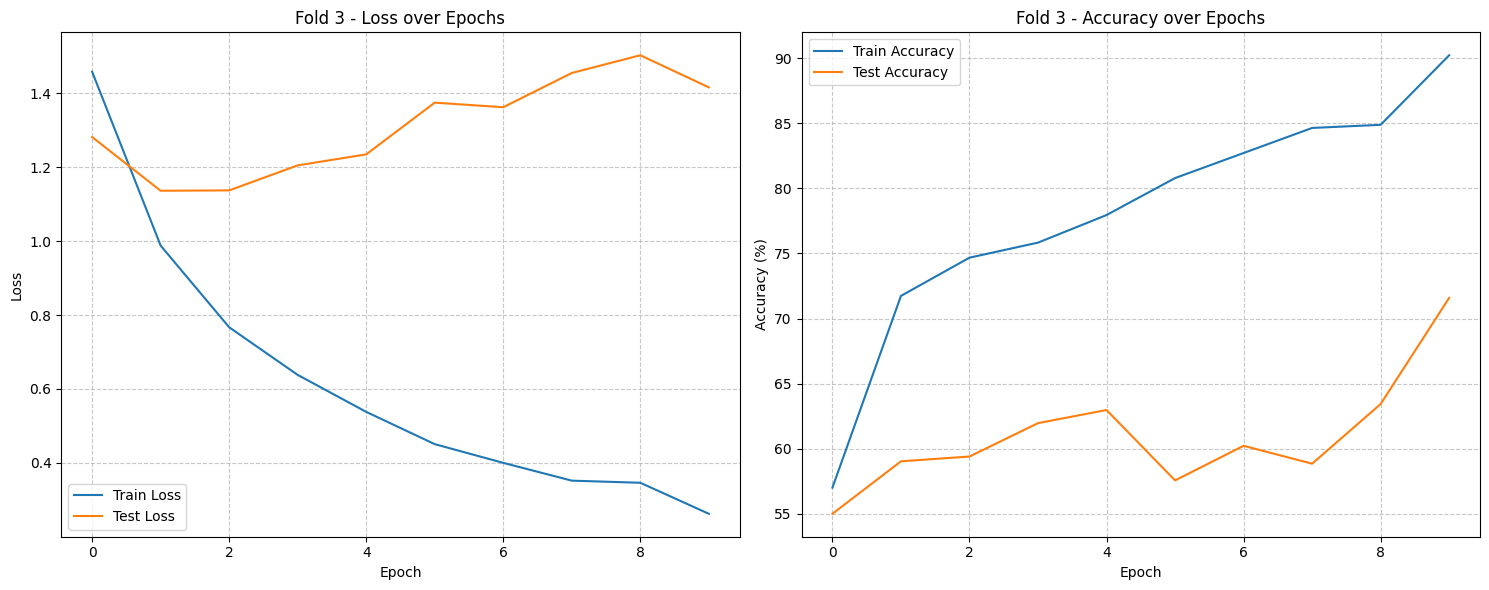

In [7]:
# Store results for this fold
results['fold_accuracies'].append(finetune_history['best_acc'])
results['confusion_matrices'].append(finetune_history['confusion_matrix'])
results['finetune_histories'].append(finetune_history)

logger.info(f"Fold {fold + 1} - Best Test Accuracy: {finetune_history['best_acc']:.2f}%")

# Print finetune_history structure to debug
print(f"Fold {fold + 1} - finetune_history keys:", finetune_history.keys())

# Plot fine-tuning loss and accuracy for this fold
plt.figure(figsize=(15, 6))

# Adjust plotting based on available keys
if 'train_loss' in finetune_history and 'test_loss' in finetune_history:
    # Single values per epoch
    plt.subplot(1, 2, 1)
    plt.plot(finetune_history['train_loss'], label='Train Loss')
    plt.plot(finetune_history['test_loss'], label='Test Loss')
    plt.title(f'Fold {fold+1} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(finetune_history['train_acc'], label='Train Accuracy')
    plt.plot(finetune_history['test_acc'], label='Test Accuracy')
    plt.title(f'Fold {fold+1} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
elif all(key in finetune_history for key in ['losses', 'accs']):
    # If using different key names
    plt.subplot(1, 2, 1)
    if 'train_losses' in finetune_history['losses']:
        plt.plot(finetune_history['losses']['train_losses'], label='Train Loss')
        plt.plot(finetune_history['losses']['test_losses'], label='Test Loss')
    else:
        plt.plot(finetune_history['losses'], label='Loss')
    plt.title(f'Fold {fold+1} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    if 'train_accs' in finetune_history['accs']:
        plt.plot(finetune_history['accs']['train_accs'], label='Train Accuracy')
        plt.plot(finetune_history['accs']['test_accs'], label='Test Accuracy')
    else:
        plt.plot(finetune_history['accs'], label='Accuracy')
    plt.title(f'Fold {fold+1} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
else:
    # If there are epoch entries with loss and accuracy in each
    if 'epochs' in finetune_history:
        epochs = list(range(1, len(finetune_history['epochs'])+1))
        train_losses = [epoch_data.get('train_loss', 0) for epoch_data in finetune_history['epochs']]
        test_losses = [epoch_data.get('test_loss', 0) for epoch_data in finetune_history['epochs']]
        train_accs = [epoch_data.get('train_acc', 0) for epoch_data in finetune_history['epochs']]
        test_accs = [epoch_data.get('test_acc', 0) for epoch_data in finetune_history['epochs']]
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.title(f'Fold {fold+1} - Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accs, label='Train Accuracy')
        plt.plot(epochs, test_accs, label='Test Accuracy')
        plt.title(f'Fold {fold+1} - Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    else:
        # As a last resort, just plot the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(finetune_history['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Fold {fold+1} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

plt.savefig(fold_dir / 'finetune_metrics.png')
plt.tight_layout()
plt.show()

### 7. Calculate and Visualize Final Results
Here we calculate summary statistics and visualize the cumulative confusion matrix.

INFO:__main__:
Final Results:
INFO:__main__:Mean Accuracy: 71.59% +/- 0.00%
INFO:__main__:
Cumulative Confusion Matrix:
INFO:__main__:
[[132   0   0   0  27  14]
 [  0 156   0   0   0  17]
 [  9  10   9  13   1 129]
 [  5   0   0 167   7   7]
 [ 14   0   1   0 151  32]
 [  2   2   0   0  20 166]]


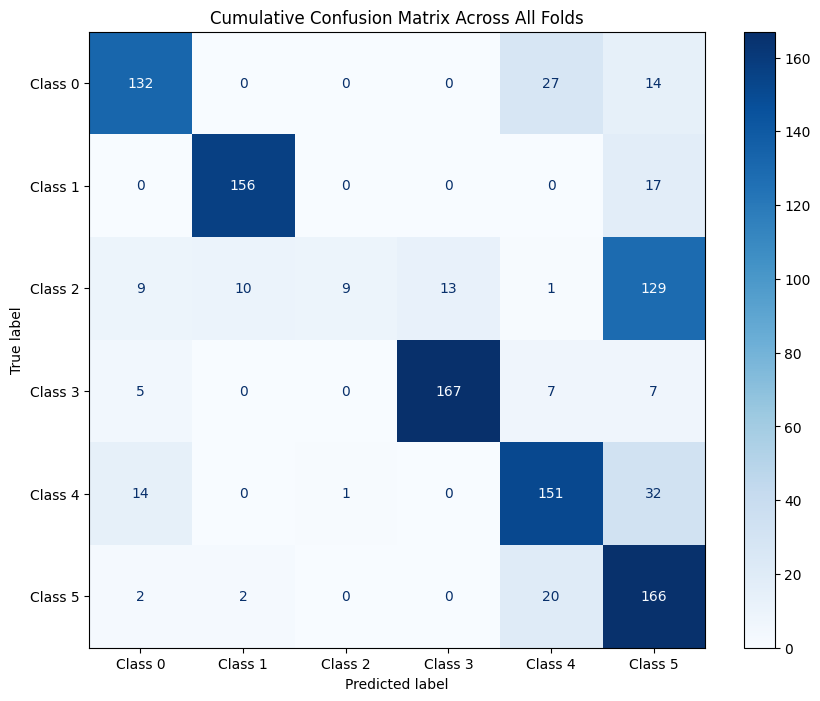

Structure of first finetune_history: dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'best_acc', 'best_epoch', 'confusion_matrix'])


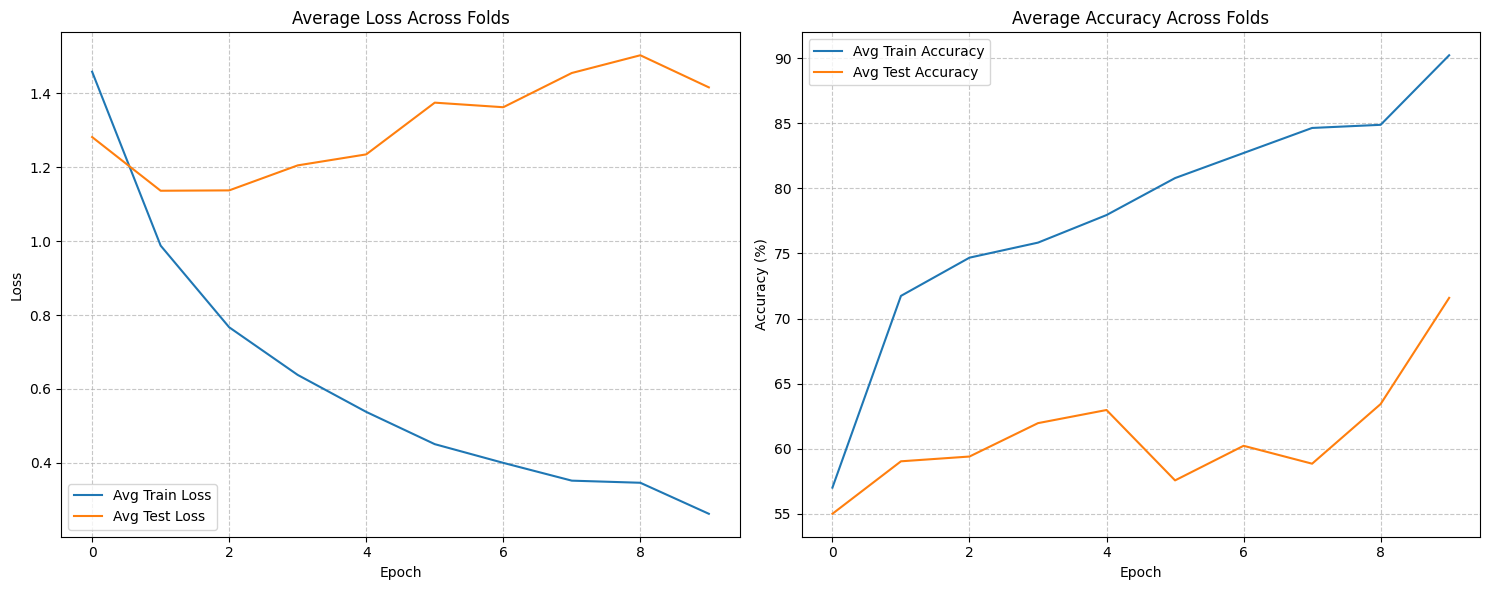


Experiment completed!
Results saved to /mnt/batch/tasks/shared/LS_root/mounts/clusters/habibirani-gpu/code/Users/habibirani/t-nnclr/experiments/20250324_202726


In [8]:
# Calculate and log final results
accuracies = np.array(results['fold_accuracies'])
cumulative_confusion = sum(results['confusion_matrices'])

logger.info("\nFinal Results:")
logger.info(f"Mean Accuracy: {accuracies.mean():.2f}% +/- {accuracies.std():.2f}%")
logger.info("\nCumulative Confusion Matrix:")
logger.info("\n" + str(cumulative_confusion))

# Visualize the cumulative confusion matrix with a heatmap
plt.figure(figsize=(10, 8))
class_names = ['Class ' + str(i) for i in range(len(np.unique(y)))]
cm_display = ConfusionMatrixDisplay(confusion_matrix=cumulative_confusion, display_labels=class_names)
cm_display.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Cumulative Confusion Matrix Across All Folds')
plt.savefig(experiment_dir / 'confusion_matrix.png')
plt.show()

# Examine the structure of finetune_histories
print("Structure of first finetune_history:", results['finetune_histories'][0].keys())

# Skip the average metrics if the required keys aren't present
try:
    # Check if 'train_loss' or 'train_losses' is used
    key_mapping = {}
    if 'train_loss' in results['finetune_histories'][0]:
        key_mapping = {
            'train_losses': 'train_loss',
            'test_losses': 'test_loss',
            'train_accs': 'train_acc',
            'test_accs': 'test_acc'
        }
    
    # Plot average training and testing curves across folds
    plt.figure(figsize=(15, 6))
    
    # Loss subplot
    plt.subplot(1, 2, 1)
    
    if key_mapping:
        # Using the alternative key names
        avg_train_losses = np.mean([hist[key_mapping['train_losses']] 
                                    for hist in results['finetune_histories']], axis=0)
        avg_test_losses = np.mean([hist[key_mapping['test_losses']] 
                                    for hist in results['finetune_histories']], axis=0)
    else:
        # Using the original key names
        avg_train_losses = np.mean([hist['train_losses'] 
                                    for hist in results['finetune_histories']], axis=0)
        avg_test_losses = np.mean([hist['test_losses'] 
                                    for hist in results['finetune_histories']], axis=0)
    
    plt.plot(avg_train_losses, label='Avg Train Loss')
    plt.plot(avg_test_losses, label='Avg Test Loss')
    plt.title('Average Loss Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Accuracy subplot
    plt.subplot(1, 2, 2)
    
    if key_mapping:
        # Using the alternative key names
        avg_train_accs = np.mean([hist[key_mapping['train_accs']] 
                                  for hist in results['finetune_histories']], axis=0)
        avg_test_accs = np.mean([hist[key_mapping['test_accs']] 
                                 for hist in results['finetune_histories']], axis=0)
    else:
        # Using the original key names
        avg_train_accs = np.mean([hist['train_accs'] 
                                  for hist in results['finetune_histories']], axis=0)
        avg_test_accs = np.mean([hist['test_accs'] 
                                 for hist in results['finetune_histories']], axis=0)
    
    plt.plot(avg_train_accs, label='Avg Train Accuracy')
    plt.plot(avg_test_accs, label='Avg Test Accuracy')
    plt.title('Average Accuracy Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.savefig(experiment_dir / 'average_metrics.png')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot average metrics: {e}")
    print("Skipping average metrics visualization.")

# Save final results
np.save(experiment_dir / 'accuracies.npy', accuracies)
np.save(experiment_dir / 'confusion_matrices.npy', results['confusion_matrices'])
np.save(experiment_dir / 'cumulative_confusion.npy', cumulative_confusion)

# Save summary statistics as text
with open(experiment_dir / 'summary.txt', 'w') as f:
    f.write("Experiment Configuration:\n")
    f.write(f"Freeze encoder: {finetune_config.freeze_encoder}\n")
    f.write(f"Encoder learning rate: {finetune_config.encoder_lr}\n")
    f.write(f"Head learning rate: {finetune_config.head_lr}\n")
    f.write(f"Pretrain epochs: {pretrain_epochs}\n")
    f.write(f"Finetune epochs: {finetune_epochs}\n\n")
    f.write(f"Mean Accuracy: {accuracies.mean():.2f}% +/- {accuracies.std():.2f}%\n")
    f.write(f"Individual Fold Accuracies: {accuracies.tolist()}\n")
    f.write(f"\nCumulative Confusion Matrix:\n{cumulative_confusion}")

print("\nExperiment completed!")
print(f"Results saved to {experiment_dir}")